In [17]:
#-- import modules--

import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import math
import astropy_healpix as ah
from astropy import units as u
import healpy as hp
import ligo.skymap.plot           
from ligo.skymap.tool import ArgumentParser, FileType
from ligo.skymap.io import fits
from ligo.skymap.tool import ligo_skymap_contour
from ligo.skymap.postprocess import contour
from ligo.skymap import postprocess
from astropy.coordinates import SkyCoord
from astropy.time import Time
import scipy.stats as st
from scipy.optimize import bisect

from ligo.skymap import io
from ligo.skymap.bayestar import rasterize
from ligo.skymap import version
from astropy.table import Table
from astropy.time import Time
import numpy as np
import os
import sys
import pickle
from ligo.skymap.kde import Clustered2Plus1DSkyKDE, Clustered2DSkyKDE
import logging
from textwrap import wrap
from pycbc.detector import Detector

In [18]:
#-- reading PE samples --

def pos_samples(filename):
    
    """Function to load the posterior samples of the GW source parameters from the posterior samples hdf file obtained 
    after Bayesian Parameter Estimation of the Gravitational Wave Event
    
    Parameters
    ----------
    filename : filename or path of the hdf file containing the posterior samples 
    
    Returns
    -------
    A multi-dimensional matrix containing the posterior samples of each parameter arranged in columns """
    
    file = h5py.File(filename, 'r')

    mchirp, q, chi_eff = np.array(file['Mc']), np.array(file['mass_ratio']), np.array(file['chi_eff'])    
    iota, ra, dec = np.array(file['iota']), np.array(file['ra']), np.array(file['dec'])
    z =  np.array(file['z'])
    dL =  np.array(file['dL'])
        
    return np.column_stack((mchirp, q, chi_eff, iota, ra, dec, dL, z))


In [25]:
def create_fits_file(network, ra_samps, dec_samps, ci=90):
    
    """Function to create healpix fits file corresponding to the right-ascension(ra) and declination(delta)
    posterior samples obtained from Bayesian Parameter Estimation of the Gravitational Wave Event.
    
    Parameters
    ----------
    network  : GW detector network observing the event
    ra_samps : posterior samples for right ascension
    dec_samps: posterior samples for declination
    ci       : credible interval (default = 90%)
    
    Returns
    -------
    None: Creates a fits file and stores it """
    
    #-- samples for calculating KDE --
    pts = np.column_stack((ra_samps, dec_samps)) 
    
    #-- KDE function params
    trials = 5
    jobs = 10
    
    #-- Evaluating ClusteredKDE using a k-means clustering algorithm
    
    skypost = Clustered2DSkyKDE(pts, trials=trials, jobs=trials)

    hpmap = skypost.as_healpix(top_nside=16)
    
    #-- writing and saving the fits files --
    io.write_sky_map(os.getcwd() + '/healpix_from_posterior_for_skymap_{}.fits.gz'.format(network), hpmap, nest=True)

    return None

In [27]:
#-- injected parameters --
#-- Let us suppose these are true sky-location parameters for the source --

ra = 3.446     # radians
dec = -0.408   # radians

In [28]:
#-- reading post_samples --

samps_LHV = pos_samples(os.getcwd()+'/posterior_samples_L1H1V1_GW170817.hdf')
                        

In [29]:
#-- ra & dec samps --

LHV_ra_samps,LHV_dec_samps = samps_LHV[:,4], samps_LHV[:,5]  #-- location of columns with ra and dec samples --


In [30]:
networks = {'L1H1V1': [LHV_ra_samps, LHV_dec_samps]}

for key, vals in networks.items():
    
    network = key
    ra_samps = vals[0]
    dec_samps = vals[1]
    create_fits_file(network=network, ra_samps=ra_samps, dec_samps=dec_samps, ci=90)

  0%|          | 0/200 [00:00<?, ?it/s]

adaptive refinement round 0 of 8 ...
adaptive refinement round 1 of 8 ...
adaptive refinement round 2 of 8 ...
adaptive refinement round 3 of 8 ...
adaptive refinement round 4 of 8 ...
adaptive refinement round 5 of 8 ...
adaptive refinement round 6 of 8 ...
adaptive refinement round 7 of 8 ...
adaptive refinement round 8 of 8 ...


### $\Rightarrow$ Type 1: Astro Hours - Globe Skymap

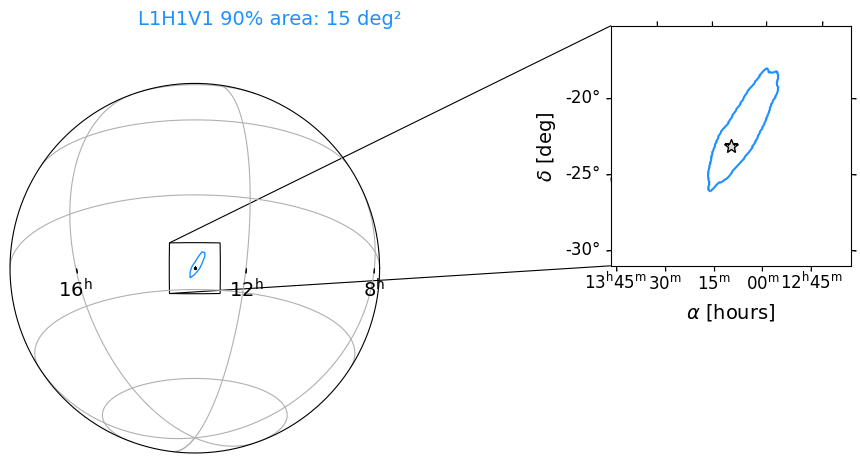

In [34]:
fontsize = 14

#-- plotting arguments ----
axes_args = {}
axes_args['projection'] = 'astro hours'
axes_args['projection'] += ' ' + 'globe'
axes_args['center'] = SkyCoord(ra, dec, unit='rad')    # This coordinate is chosen so that the broken ring in 2 Det case is visible 
ax = plt.axes(**axes_args)
ax.grid()
ax.tick_params(which='both', labelsize=fontsize)

methods = ['L1H1V1']
colors = ['dodgerblue']

#-- containers --
skymap = {}
metadata = {}
nside = {}
text = {}
vals = {}
cs = {}
deg2perpix = {}
probperdeg = {}

levels = [90] # credible levels
pp = np.round([levels[0]])#.astype(int)
lw = 1.5
j = 0

for m in methods:
    
    skymap[m], metadata[m] =  fits.read_sky_map(os.getcwd() + '/healpix_from_posterior_for_skymap_{}.fits.gz'.format(m), nest=None)
    nside[m] = ah.npix_to_nside(len(skymap[m]))
    
    #--Convert sky map from probability to probability per square degree ---
    deg2perpix[m] = ah.nside_to_pixel_area(nside[m]).to_value(u.deg**2)
    probperdeg[m] = skymap[m] / deg2perpix[m]
    
    vals[m] = 100 * postprocess.find_greedy_credible_levels(skymap[m])
    cs[m] = ax.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=1, levels=levels)

    #-- for printing the '' % credible region on the globe ---
    fmt = '%g%%'            
    text[m] = []  
    
    #-- for area of 90% credible region ---
    ii = np.round(np.searchsorted(np.sort(vals[m]), [levels[0]]) * deg2perpix[m]).astype(int)

    for i, p in zip(ii, pp):

        text[m].append('{} {:d}% area: {:,d} deg²'.format(m, p, i))    # for typing 90% credible area value in plot
        
    j += 1

ax.text(1.059, 1.16, '\n'.join(text[methods[0]]), transform=ax.transAxes, ha='right', color=colors[0], fontsize=fontsize)

#-- for injected ra, dec ---
ax.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=2)

#-- Axes Inset ---
#center = SkyCoord.from_name("NGC 4993")  # in degrees
ra_deg = ra*(180/np.pi)
dec_deg = dec*(180/np.pi)

ax_inset = plt.axes([1.1, 0.5, 0.5, 0.5], projection='astro zoom', center=SkyCoord(ra_deg, dec_deg, unit="deg"), radius=8*u.deg)
# ax_inset.tick_params(which='both', labelsize=fontsize)
# ax_inset.tick_params(which='both', labelsize=fontsize)
ax_inset.set_xlabel(r'$\alpha$ [hours]', fontsize=fontsize)
ax_inset.set_ylabel(r'$\delta$ [deg]', fontsize=fontsize)
ax_inset.tick_params(labelsize=fontsize-2)

ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

j = 0
for m in methods:
    ax_inset.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=lw, levels=levels)
    j += 1

ax_inset.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=10)   # for host galaxy
#ax_inset.imshow_hpx((probperdeg['L1H1V1A0'], 'ICRS'), nested=metadata['L1H1V1A0']['nest'], cmap='PuBu')

plt.savefig("globe_GW170817_skymap_{}.png".format(methods[0]), dpi=200, bbox_inches='tight')
plt.show()

### $\Rightarrow$ Type 2: Contour Skymap (in Astro-Hours)

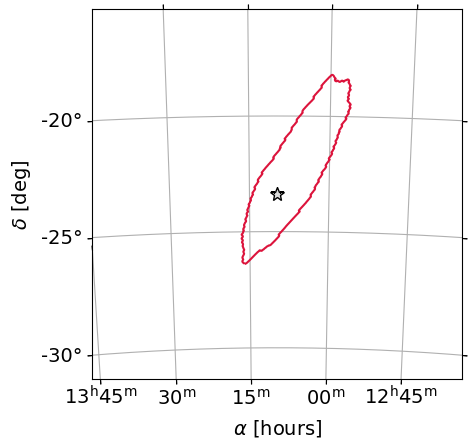

In [33]:
fontsize = 14

#-- plotting arguments ----
axes_args = {}
axes_args['projection'] = 'astro hours'
axes_args['projection'] += ' ' + 'zoom'
axes_args['center'] = SkyCoord(ra, dec, unit='rad')    
axes_args['radius'] = 8*u.deg   # unit (see imports)
ax = plt.axes(**axes_args)
ax.grid()
ax.tick_params(which='both', labelsize=fontsize)

methods = ['L1H1V1']
colors = ['crimson']

#-- containers --
skymap = {}
metadata = {}
nside = {}
text = {}
vals = {}
cs = {}
deg2perpix = {}
probperdeg = {}

levels = [90] # credible levels
pp = np.round([levels[0]])#.astype(int)
lw = 1.5
j = 0

for m in methods:
    
    skymap[m], metadata[m] =  fits.read_sky_map(os.getcwd() + '/healpix_from_posterior_for_skymap_{}.fits.gz'.format(m), nest=None)
    nside[m] = ah.npix_to_nside(len(skymap[m]))
    
    #--Convert sky map from probability to probability per square degree ---
    deg2perpix[m] = ah.nside_to_pixel_area(nside[m]).to_value(u.deg**2)
    probperdeg[m] = skymap[m] / deg2perpix[m]
    
    vals[m] = 100 * postprocess.find_greedy_credible_levels(skymap[m])
    cs[m] = ax.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=1.5, levels=levels)

    #-- for printing the '' % credible region on the globe ---
    fmt = '%g%%'            
    text[m] = []  
    
    #-- for area of 90% credible region ---
    ii = np.round(np.searchsorted(np.sort(vals[m]), [levels[0]]) * deg2perpix[m]).astype(int)
    
    for i, p in zip(ii, pp):

        text[m].append('{} {:d}% area: {:,d} deg²'.format(m, p, i))    # for typing 90% credible area value in plot
        
    j += 1


#-- putting legends on the skymaps ---
#ax.text(1.059, 1.40, '\n'.join(text[methods), transform=ax.transAxes, ha='right', color=colors[0], fontsize=fontsize)
#ax.text(1.059, 1.29, '\n'.join(text['L1H1V1A0']), transform=ax.transAxes, ha='right', color=colors[1], fontsize=fontsize)

#-- for injected ra, dec ---
ax.set_xlabel(r'$\alpha$ [hours]', fontsize=fontsize)
ax.set_ylabel(r'$\delta$ [deg]', fontsize=fontsize)
ax.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=10)
#ax.imshow_hpx((probperdeg['LHVA'], 'ICRS'), nested=metadata['LHVA']['nest'], cmap='PuBu')
#ax.clabel(cs['LHV'])
plt.savefig("contour_GW170817_skymap_{}.png".format(methods[0]), dpi=200, bbox_inches='tight')
plt.show()

### $\Rightarrow$ Type 3: Mollweide Skymap (in Astro-Hours)

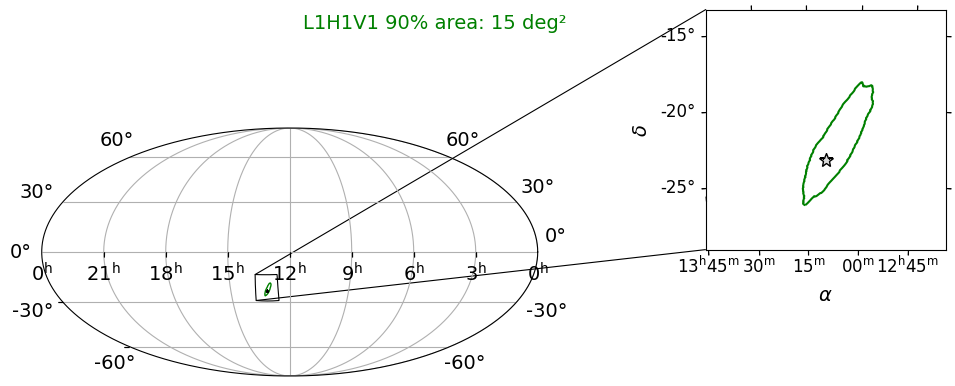

In [35]:
fontsize = 14

#-- plotting arguments ----
axes_args = {}
axes_args['projection'] = 'astro hours'
axes_args['projection'] += ' ' + 'mollweide'
# axes_args['center'] = SkyCoord('13h -40d')    # This coordinate is chosen so that the broken ring in 2 Det case is visible 
ax = plt.axes(**axes_args)
ax.grid()
ax.tick_params(which='both', labelsize=fontsize)

methods = ['L1H1V1']
colors = ['green']

#-- containers --
skymap = {}
metadata = {}
nside = {}
text = {}
vals = {}
cs = {}
deg2perpix = {}
probperdeg = {}

levels = [90] # credible levels
pp = np.round([levels[0]]).astype(int)
lw = 1.5
j = 0

for m in methods:
    
    skymap[m], metadata[m] =  fits.read_sky_map(os.getcwd() + '/healpix_from_posterior_for_skymap_{}.fits.gz'.format(m), nest=None)
    nside[m] = ah.npix_to_nside(len(skymap[m]))
    
    #--Convert sky map from probability to probability per square degree ---
    deg2perpix[m] = ah.nside_to_pixel_area(nside[m]).to_value(u.deg**2)
    probperdeg[m] = skymap[m] / deg2perpix[m]
    
    vals[m] = 100 * postprocess.find_greedy_credible_levels(skymap[m])
    cs[m] = ax.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=1, levels=levels)

    #-- for printing the '' % credible region on the globe ---
    fmt = '%g%%'            
    text[m] = []  
    
    #-- for area of 90% credible region ---
    ii = np.round(np.searchsorted(np.sort(vals[m]), [levels[0]]) * deg2perpix[m]).astype(int)

    for i, p in zip(ii, pp):

        text[m].append('{} {:d}% area: {:,d} deg²'.format(m, p, i))    # for typing 90% credible area value in plot
        
    j += 1

# ax.imshow_hpx((probperdeg['PyCBC'], 'ICRS'), nested=metadata['PyCBC']['nest'], cmap='PuBu')

#-- putting legends on the skymaps ---
ax.text(1.059, 1.40, '\n'.join(text[methods[0]]), transform=ax.transAxes, ha='right', color=colors[0], fontsize=fontsize)

#-- for injected ra, dec ---
ax.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=2)

#-- Axes Inset ---
#center = SkyCoord.from_name("NGC 4993")  # in degrees
ra_deg = ra*(180/np.pi)
dec_deg = dec*(180/np.pi)

ax_inset = plt.axes([1.1, 0.5, 0.5, 0.5], projection='astro zoom', center=SkyCoord(ra_deg, dec_deg+2, unit="deg"), radius=8*u.deg)
# ax_inset.tick_params(which='both', labelsize=fontsize) 1.1, 0.5, 0.5, 0.5
# ax_inset.tick_params(which='both', labelsize=fontsize)
ax_inset.set_xlabel(r'$\alpha$', fontsize=fontsize)
ax_inset.set_ylabel(r'$\delta$', fontsize=fontsize)
ax_inset.tick_params(labelsize=fontsize-2)

ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

j = 0
for m in methods:
    ax_inset.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=lw, levels=levels)
    j += 1

ax_inset.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=10)   # for host galaxy
#ax_inset.imshow_hpx((probperdeg['LHVA'], 'ICRS'), nested=metadata['LHVA']['nest'], cmap='PuBu')

plt.savefig("mollweide_GW170817_skymap_{}.png".format(methods[0]), dpi=200, bbox_inches='tight')
plt.show()

In [34]:
help(ax.clabel)

Help on method clabel in module matplotlib.axes._axes:

clabel(CS, levels=None, **kwargs) method of ligo.skymap.plot.allsky.AstroHoursZoomAxes instance
    Label a contour plot.
    
    Adds labels to line contours in given `.ContourSet`.
    
    Parameters
    ----------
    CS : `.ContourSet` instance
        Line contours to label.
    
    levels : array-like, optional
        A list of level values, that should be labeled. The list must be
        a subset of ``CS.levels``. If not given, all levels are labeled.
    
    **kwargs
        All other parameters are documented in `~.ContourLabeler.clabel`.



### $\Rightarrow$ If interested only in the sky-localization uncertainty (area) value 

In [41]:
def skymap_credible_area(ra_samps, dec_samps, fits_filename, ci=90):
    
    """Function to get desired level credible region skymap area. By default, calculates 90% credible sky area.
    It also creates and stores '.fits' files according to the injection number in a separate folder('fits files')
    
    Parameters
    ----------
    ra_samps : posterior samples for right ascension
    dec_samps: posterior samples for declination
    fits_filename : name that one wants to give to the healpix fits file [no extension needed]
    ci       : credible interval (default = 90%)
    
    Returns
    -------
    area : 90% credible region in delta_omega**2 """
    
    #-- samples for calculating KDE --
    pts = np.column_stack((ra_samps, dec_samps)) 
    
    #-- KDE function params (to increase the speed of evaluation we have reduced trials and jobs at the cost of small accuracy loss)
    trials = 1
    jobs = 1
    
    #-- Evaluating ClusteredKDE using a k-means clustering algorithm
    
    skypost = Clustered2DSkyKDE(pts, trials=trials, jobs=trials)

    hpmap = skypost.as_healpix(top_nside=16)
    
    #-- writing and saving the fits files --
    io.write_sky_map(os.getcwd() + '/{}.fits.gz'.format(fits_filename), hpmap, nest=True)

    #-- Calculating the skymap area from Healpix map --

    skymap, metadata = fits.read_sky_map(os.getcwd() + '/{}.fits.gz'.format(fits_filename), nest=None)
    nside = ah.npix_to_nside(len(skymap))

    #-- Convert sky map from probability to probability per square degree.

    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg = skymap / deg2perpix

    levels = [ci]   # this should be provided as a list
                    #(see: https://github.com/lpsinger/ligo.skymap/blob/main/ligo/skymap/tool/ligo_skymap_plot.py)

    #-- for contours 
    vals = 100 * postprocess.find_greedy_credible_levels(skymap)

    #-- for area of 90% credible region 

    pp = np.round([ci]).astype(int)               
    area = (np.searchsorted(np.sort(vals), [ci]) * deg2perpix)[0]
    
    print("90% credible sky-localization area: {} sq meters".format(area))
    
    return area

In [44]:
sky_area = skymap_credible_area(ra_samps=LHV_ra_samps, dec_samps=LHV_dec_samps,\
                                fits_filename='test_fits_file')

  0%|          | 0/40 [00:00<?, ?it/s]

adaptive refinement round 0 of 8 ...
adaptive refinement round 1 of 8 ...
adaptive refinement round 2 of 8 ...
adaptive refinement round 3 of 8 ...
adaptive refinement round 4 of 8 ...
adaptive refinement round 5 of 8 ...
adaptive refinement round 6 of 8 ...
adaptive refinement round 7 of 8 ...
adaptive refinement round 8 of 8 ...
90% credible sky-localization area: 15.290881098690944 sq meters
